### Stock ID

In [ ]:
STOCK_ID = [
    "50200",
    "80580",
    "69200",
    "80010",
    "69520",
    "43930",
    "91040",
    "79740",
    "72030",
    "24320",
    "46890",
    "40630",
    "51080",
    "96970",
    "99830",
    "99840",
    "45680",
    "18120",
    "70110",
    "88010",
    "36350",
    "48160",
    "83060",
    "54110",
    "68570"
]

def stock_id_preprocessing(stock_ids):
    result = []
    for stock in stock_ids:
        if stock.endswith("0"):
            stock = stock[:-1] + ".T"
        result.append(stock)
    return result

STOCK_ID = stock_id_preprocessing(STOCK_ID)
print(STOCK_ID)


['5020.T', '8058.T', '6920.T', '8001.T', '6952.T', '4393.T', '9104.T', '7974.T', '7203.T', '2432.T', '4689.T', '4063.T', '5108.T', '9697.T', '9983.T', '9984.T', '4568.T', '1812.T', '7011.T', '8801.T', '3635.T', '4816.T', '8306.T', '5411.T', '6857.T']


# ROAの底打ち傾向 - ROA Bottoming Trend

In [104]:
import yfinance as yf
import numpy as np
from itertools import product

def slope_of_list(y):
    """
    y: list hoặc numpy array
    return: slope (float)
    """
    y = np.array(y)
    x = np.arange(len(y))

    # linear regression: y = m*x + b
    m, b = np.polyfit(x, y, 1)
    return m

def fetch_roa_multi_year(stock_id):
    ticker = yf.Ticker(stock_id)
    financials = ticker.financials
    balance_sheet = ticker.balance_sheet
    if financials.empty or balance_sheet.empty:
        return None
    roa_by_year = {}
    for col in financials.columns:
        try:
            net_income = financials.loc["Net Income", col]
            total_assets = balance_sheet.loc["Total Assets", col]

            if total_assets != 0:
                roa_by_year[col.year] = net_income / total_assets

        except KeyError:
            continue

    keys = list(roa_by_year.keys())
    keys.sort()

    result = [(roa_by_year[key]) for key in keys]

    return result

def Rule(roa_level, trend):
    if roa_level == "HIGH" and trend == "IMPROVING":
        return "STRONG", 90

    if (roa_level == "MEDIUM" and trend == "IMPROVING") or \
       (roa_level == "HIGH" and trend == "STABLE"):
        return "GOOD", 75

    if (roa_level == "LOW" and trend == "IMPROVING") or \
       (roa_level == "MEDIUM" and trend == "STABLE") or \
       (roa_level == "HIGH" and trend == "DECLINING"):
        return "NEUTRAL", 60

    if (roa_level == "LOW" and trend == "STABLE") or \
       (roa_level == "MEDIUM" and trend == "DECLINING"):
        return "WEAK", 45

    if roa_level == "LOW" and trend == "DECLINING":
        return "DETERIORATING", 25

    return "UNKNOWN", 0

def in_range(x, a, b):
    return a < x < b

## ---- Fuzzy ----
# ROA:
# Low       : [0.03 → 0.06] (left-shoulder)
# Medium    : [0.04, 0.07, 0.11] (triangular)
# High      : [0.08 → 0.12] (right-shoulder)

# Trend:
# Declining : [-0.08 → -0.02] (left-shoulder)
# Stable    : [-0.06, 0.00, 0.06] (triangular)
# Improving : [0.02 → 0.08] (right-shoulder)

MAP_ROA = {
    "LOW": (0.03, 0.06),
    "MEDIUM_1": (0.04, 0.07),
    "MEDIUM_2": (0.07, 0.11),
    "HIGH": (0.08, 0.12)
}

MAP_TREND = {
    "DECLINING": (-0.08, -0.02),
    "STABLE_1": (-0.06, 0.00),
    "STABLE_2": (0.00, 0.06),
    "IMPROVING": (0.02, 0.08)
}

def fuzzy_product(roa_level, trend, MAP_ROA, MAP_TREND):
    # print(roa_level, trend, MAP_ROA, MAP_TREND)
    FUZZY_ROA = []
    FUZZY_TREND = []

    for key, value in MAP_ROA.items():
        if in_range(roa_level, value[0], value[1]):
            max_value = max(value[1] , roa_level)
            min_value = min(value[0], roa_level)
            weight = (max_value - min_value)/ (value[1] - value[0])
            FUZZY_ROA.append((key, value, roa_level, weight))
            break
        elif roa_level < 0.03:
            FUZZY_ROA.append(("LOW", value, roa_level, 1.0))
            break
        elif roa_level > 0.12:
            FUZZY_ROA.append(("HIGH", value, roa_level, 1.0))
            break
    
    for key, value in MAP_TREND.items():
        if in_range(trend, value[0], value[1]):
            max_value = max(value[1] , trend)
            min_value = min(value[0], trend)
            weight = (value[1] - trend) / (value[1] - value[0])
            FUZZY_TREND.append((key, value, trend, weight))
            break
        elif trend < -0.08:
            FUZZY_TREND.append(("DECLINING", value, trend, 1.0))
            break
        elif trend > 0.08:
            FUZZY_TREND.append(("IMPROVING", value, trend, 1.0))
            break
    return list(product(FUZZY_ROA, FUZZY_TREND))

def fuzzy_calculation(fuzzy_product):
    weights = []
    
    values = []
    for item in fuzzy_product:
        rule_value = Rule(item[0][0].split("_")[0], item[1][0].split("_")[0])
        weight = min(item[0][3], item[1][3])
        weights.append(weight)
        values.append(rule_value[1] * weight)
    final_score = sum(weight * value for weight, value in zip(weights, values)) / sum(weights)

    return final_score

test_stock_id = "AAPL"
data = fetch_roa_multi_year(test_stock_id)
min_value = min(data)
min_index = data.index(min_value)

print("ROA data:", data)    

if min_index == len(data) - 1:
    # Left
    slope = slope_of_list(data)
if min_index == 0:
    # Right
    slope = slope_of_list(data)
if 0 < min_index < len(data) - 1:
    # Left
    slope_left = slope_of_list(data[min_index:])

roe_finall_data = data[-1]

fuzzy_product = fuzzy_product(roe_finall_data, slope, MAP_ROA, MAP_TREND)
print(fuzzy_product)
final_score = fuzzy_calculation(fuzzy_product)
final_score

ROA data: [np.float64(nan), np.float64(0.2829244092925685), np.float64(0.27509834563776475), np.float64(0.25682503150857583), np.float64(0.3117962593356549)]
[]


ZeroDivisionError: division by zero

In [64]:
A = [(1,), (2,)]
B = [(3,), (4,)]
from itertools import product

list(product(A, B))


[((1,), (3,)), ((1,), (4,)), ((2,), (3,)), ((2,), (4,))]

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

def plot_list_with_slope_and_angle(y):
    y = np.array(y)
    x = np.arange(len(y))

    # Linear regression
    m, b = np.polyfit(x, y, 1)

    # Góc slope
    angle_rad = np.arctan(m)
    angle_deg = np.degrees(angle_rad)

    # Fit line
    y_fit = m * x + b

    plt.figure()
    plt.plot(x, y, marker='o', label="Data")
    plt.plot(x, y_fit, linestyle='--', label="Linear fit")

    # Trục X tham chiếu
    plt.axhline(b, linestyle=':', color='gray')

    # === VẼ VECTOR SLOPE ===
    x0 = 0
    y0 = b
    dx = len(y) - 1
    dy = m * dx

    plt.arrow(
        x0, y0,
        dx, dy,
        length_includes_head=True,
        head_width=0.03 * np.ptp(y),
        head_length=0.3,
        fc='black',
        ec='black'
    )

    # === VẼ CUNG GÓC (ARC) ===
    radius = dx * 0.3  # bán kính cung góc
    arc = Arc(
        (x0, y0),
        width=radius,
        height=radius,
        angle=0,
        theta1=0,
        theta2=angle_deg,
        color='red',
        linewidth=2
    )
    plt.gca().add_patch(arc)

    # Label góc
    plt.text(
        x0 + radius * 0.55,
        y0 + radius * np.sin(angle_rad) * 0.5,
        f"{angle_deg:.1f}°",
        color='red',
        fontsize=12
    )

    # Info box
    info = f"Slope = {m:.4f}\nAngle = {angle_deg:.2f}°"
    plt.text(
        0.05, 0.95, info,
        transform=plt.gca().transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle="round", alpha=0.2)
    )

    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Slope & Angle Visualization (Geometric)")
    plt.show()

    return m, angle_deg


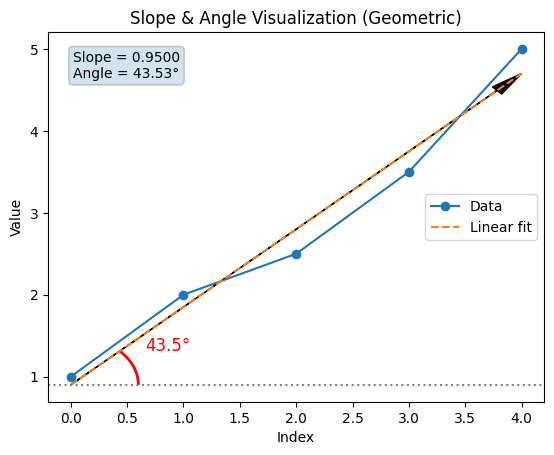

(np.float64(0.9499999999999997), np.float64(43.53119928561417))

In [40]:
y1 = [1, 2, 2.5, 3.5, 5]
plot_list_with_slope_and_angle(y1)


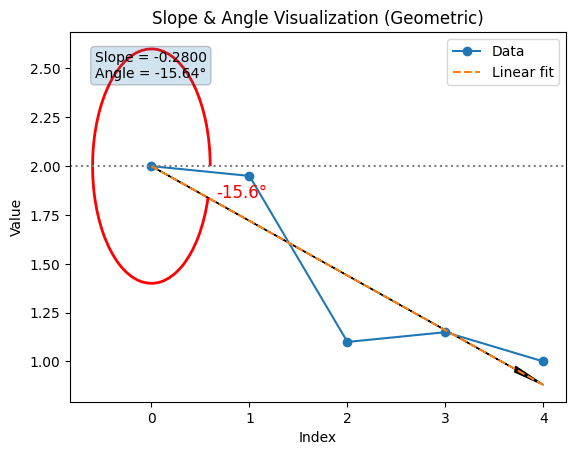

(np.float64(-0.2799999999999999), np.float64(-15.642246457208724))

In [51]:
y_up_weak = [2.00, 1.95, 1.10, 1.15, 1.0]
plot_list_with_slope_and_angle(y_up_weak)

# 資産の換金性 - Asset Liquidity